<a href="https://colab.research.google.com/github/tohpedo/wikibot/blob/main/transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#colab pro stuff, checking gpu and high ram
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')


  gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!
Tue Nov  2 15:59:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
    

In [2]:
#install depedencies hugging face
!pip install pytorch-pretrained-bert pytorch-nlp pytorch_transformers
#!pip install folium

#import required packages
import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig, BertModel
from pytorch_transformers import AdamW, BertForQuestionAnswering
from tqdm import tqdm, trange
import pandas as pd
import io
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



     |████████████████████████████████| 123 kB 7.5 MB/s 
     |████████████████████████████████| 90 kB 11.0 MB/s 
     |████████████████████████████████| 176 kB 88.2 MB/s 
     |████████████████████████████████| 131 kB 91.2 MB/s 
     |████████████████████████████████| 895 kB 74.5 MB/s 
     |████████████████████████████████| 1.2 MB 80.8 MB/s 
     |████████████████████████████████| 79 kB 9.3 MB/s 
     |████████████████████████████████| 8.1 MB 79.7 MB/s 
     |████████████████████████████████| 138 kB 64.8 MB/s 
     |████████████████████████████████| 127 kB 74.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible

In [3]:
#import helper functions for squad dataset
!wget 'https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad.py'
!wget 'https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad_evaluate.py'

from utils_squad import (read_squad_examples, convert_examples_to_features,
                         RawResult, write_predictions,
                         RawResultExtended, write_predictions_extended)
from utils_squad_evaluate import EVAL_OPTS, main as evaluate_on_squad, plot_pr_curve

--2021-11-02 15:59:27--  https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41529 (41K) [text/plain]
Saving to: ‘utils_squad.py’

utils_squad.py      100%[===================>]  40.56K  --.-KB/s    in 0.003s  

2021-11-02 15:59:27 (15.2 MB/s) - ‘utils_squad.py’ saved [41529/41529]

--2021-11-02 15:59:27--  https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad_evaluate.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 2

In [4]:
def isGPUAvailable():
  #check if GPU is available 
  gpu = tf.test.gpu_device_name()
  if gpu != '/device:GPU:0':
    print('No GPU available')
  else:
    print('GPU is available')

isGPUAvailable()

GPU is available


In [5]:
#mount colab drive
from google.colab import drive
drive.mount('/content/drive/')
!ls

Mounted at /content/drive/
drive  __pycache__  sample_data  utils_squad_evaluate.py  utils_squad.py


In [6]:
#set seeds
np.random.seed(1234)
torch.manual_seed(1234)

In [7]:
#read in training data
train_data_file = '/content/drive/My Drive/train-v2.0.json'
train_data_raw = read_squad_examples(input_file=train_data_file,
                                is_training=True,
                                version_2_with_negative=True)

In [8]:
#inspecting first records
sample_records = train_data_raw[:5]
sample_records

[qas_id: 56be85543aeaaa14008c9063, question_text: When did Beyonce start becoming popular?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".], start_position: 39, end_position: 42,
 qas_id: 56be85543aeaaa14008c9065, question_text: What areas did Beyonce compete in when she was growing up?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈ

In [9]:
#take first 10,000 rows for training due to RAM limitation
train_data_raw = train_data_raw[:10000]
train_data = pd.DataFrame.from_records([vars(record) for record in train_data_raw])
train_data.head()
print(len(train_data))

10000


In [10]:
#loooking at all questions from one article
sample = train_data.sample(frac=1).head(1)
print(sample)
context = sample.doc_tokens.values
print(context)
train_data[train_data.doc_tokens.values==context]


                        qas_id  ... is_impossible
2374  5a8db90bdf8bba001a0f9baf  ...          True

[1 rows x 7 columns]
[list(['Special', 'bundles', 'of', 'the', 'game', 'contain', 'a', 'Wolf', 'Link', 'Amiibo', 'figurine,', 'which', 'unlocks', 'a', 'Wii', 'U-exclusive', 'dungeon', 'called', 'the', '"Cave', 'of', 'Shadows"', 'and', 'can', 'carry', 'data', 'over', 'to', 'the', 'upcoming', '2016', 'Zelda', 'game.', 'Other', 'Zelda-related', 'Amiibo', 'figurines', 'have', 'distinct', 'functions:', 'Link', 'and', 'Toon', 'Link', 'replenish', 'arrows,', 'Zelda', 'and', 'Sheik', 'restore', "Link's", 'health,', 'and', 'Ganondorf', 'causes', 'Link', 'to', 'take', 'twice', 'as', 'much', 'damage.'])]


,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
2361,56cda5a862d2951400fa67b4,What special item is included with certain ver...,"[Special, bundles, of, the, game, contain, a, ...",Wolf Link Amiibo figurine,7,10,False
2362,56cda5a862d2951400fa67b5,Which two Amiibo figures reload Link's stock o...,"[Special, bundles, of, the, game, contain, a, ...",Link and Toon Link,40,43,False
2363,56cda5a862d2951400fa67b6,Which two Amiibo figures heal Link?,"[Special, bundles, of, the, game, contain, a, ...",Zelda and Sheik,46,48,False
2364,56cda5a862d2951400fa67b7,Which Amiibo figure makes Link lose more healt...,"[Special, bundles, of, the, game, contain, a, ...",Ganondorf,53,53,False
2365,56cda5a862d2951400fa67b8,What is the name of the area that players with...,"[Special, bundles, of, the, game, contain, a, ...",Cave of Shadows,19,21,False
2366,56d133d017492d1400aabc20,What will special bundles of the game contain?,"[Special, bundles, of, the, game, contain, a, ...",Wolf Link Amiibo,7,9,False
2367,56d133d017492d1400aabc21,What is the level called that the special Amii...,"[Special, bundles, of, the, game, contain, a, ...",Cave of Shadows,19,21,False
2368,56d133d017492d1400aabc22,What characters will be able to replenish arrows?,"[Special, bundles, of, the, game, contain, a, ...",Link and Toon,40,42,False
2369,56d133d017492d1400aabc23,What figures restore health?,"[Special, bundles, of, the, game, contain, a, ...",Zelda and Sheik,46,48,False
2370,5a8db90bdf8bba001a0f9bab,What special item is included with certain ver...,"[Special, bundles, of, the, game, contain, a, ...",,-1,-1,True


In [11]:
#helper function to show all questions from single article, not sure if needed
import random
def print_squad_sample(train_data, line_length=14, separator_length=120):
  sample = train_data.sample(frac=1).head(1)
  context = sample.doc_tokens.values
  print('='*separator_length)
  print('CONTEXT: ')
  print('='*separator_length)
  lines = [' '.join(context[0][idx:idx+line_length]) for idx in range(0, len(context[0]), line_length)]
  for l in lines:
      print(l)
  print('='*separator_length)
  questions = train_data[train_data.doc_tokens.values==context]
  print('QUESTION:', ' '*(3*separator_length//4), 'ANSWER:')
  for idx, row in questions.iterrows():
    question = row.question_text
    answer = row.orig_answer_text
    print(question, ' '*(3*separator_length//4-len(question)+9), (answer if answer else 'No awnser found'))



In [12]:
print_squad_sample(train_data)

CONTEXT: 
In 2011, documents obtained by WikiLeaks revealed that Beyoncé was one of many entertainers
who performed for the family of Libyan ruler Muammar Gaddafi. Rolling Stone reported that
the music industry was urging them to return the money they earned for the
concerts; a spokesperson for Beyoncé later confirmed to The Huffington Post that she donated
the money to the Clinton Bush Haiti Fund. Later that year she became the
first solo female artist to headline the main Pyramid stage at the 2011 Glastonbury
Festival in over twenty years, and was named the highest-paid performer in the world
per minute.
QUESTION:                                                                                            ANSWER:
In which year was reports about Beyonce performing for Muammar Gaddafi surface?                      2011
Who did Beyonce donate the money to earned from her shows?                                           Clinton Bush Haiti Fund
Beyonce became the first female artist to perf

In [13]:
train_data['paragraph_len'] = train_data['doc_tokens'].apply(len)
train_data['question_len'] = train_data['question_text'].apply(len)
train_data.sample(frac=1).head(5)

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible,paragraph_len,question_len
7913,56dceb899a695914005b9475,Who were responsible for the revolts that ende...,"[The, Republic, of, the, Congo, received, full...",labour elements and rival political parties,23,28,False,55,70
5115,56d1333517492d1400aabc0e,What kind of background did Kanye West grow up...,"[West's, middle-class, background,, flamboyant...",middle-class,1,1,False,297,50
6992,56dafc53e7c41114004b4c0a,How many days did the plane travel with the To...,"[Internationally,, the, torch, and, its, accom...",130,71,71,False,78,55
5470,56d1f453e7d4791d009025bf,What Buddha vowed to rescue all beings from sa...,"[The, method, of, self-exertion, or, ""self-pow...",Amitabha,34,34,False,136,63
2980,56d5098a9d1b871400ae0607,What does the China Seismic Intensity Scale ca...,"[The, map, of, earthquake, intensity, publishe...",very destructive,31,32,False,187,64


In [14]:
max_seq_length = 256
print("Percentage of context's less than max_seq_length = %s%%" % (len([l for l in train_data['paragraph_len'] if l <= max_seq_length])/len(train_data) * 100))

Percentage of context's less than max_seq_length = 97.94%


In [15]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 898301.05B/s]


In [16]:
doc_stride = 128
max_seq_length = 256
max_query_length = 64
# batch size of 64 if RAM available.
batch_size = 16


features = convert_examples_to_features(examples=train_data_raw,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=True)
torch.save(features, "/content/drive/My Drive/bert_train")


In [17]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_start_positions = torch.tensor([f.start_position for f in features], dtype=torch.long)
all_end_positions = torch.tensor([f.end_position for f in features], dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_start_positions, all_end_positions,
                        all_cls_index, all_p_mask)

In [18]:
train_sampler = RandomSampler(dataset)
train_dataloader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size, drop_last=True)

In [19]:
def to_list(tensor):
    return tensor.detach().cpu().tolist()

In [20]:
import glob
checkpoints = sorted(glob.glob('/content/drive/My Drive/checkpoint*-[0-9]*'))

In [21]:

global_step = 0
train_loss_set = []
tr_loss = 0.0
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')

model.cuda()

100%|██████████| 440473133/440473133 [00:11<00:00, 38181689.11B/s]


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [22]:
param_optimizer = list(model.named_parameters())
print(param_optimizer[-2])
print(param_optimizer[-1])

('qa_outputs.weight', Parameter containing:
tensor([[-0.0231, -0.0370, -0.0441,  ...,  0.0076, -0.0057,  0.0081],
        [ 0.0022,  0.0065,  0.0223,  ..., -0.0018,  0.0032, -0.0065]],
       device='cuda:0', requires_grad=True))
('qa_outputs.bias', Parameter containing:
tensor([0., 0.], device='cuda:0', requires_grad=True))


In [23]:
#create AdamW optimizer to fine tune model
learning_rate = 5e-5
adam_epsilon=1e-8
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

In [24]:
num_train_epochs = 5

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

print("***** Running training *****")
print("  Num examples = %d" % len(dataset))
print("  Num Epochs = %d" % num_train_epochs)
print("  Batch size = %d" % batch_size)
print("  Total optimization steps = %d" % (len(train_dataloader) // num_train_epochs))

model.zero_grad()
train_iterator = trange(num_train_epochs, desc="Epoch")

for _ in train_iterator:
    epoch_iterator = tqdm(train_dataloader, desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
      if step < global_step + 1:
        continue

      model.train()
      batch = tuple(t.to(device) for t in batch)

      inputs = {'input_ids':       batch[0],
                'attention_mask':  batch[1], 
                'token_type_ids':  batch[2],  
                'start_positions': batch[3], 
                'end_positions':   batch[4]}

      outputs = model(**inputs)

      loss = outputs[0]
      train_loss_set.append(loss)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      tr_loss += loss.item()
      optimizer.step()
      model.zero_grad()
      global_step += 1
    
      if global_step % 1000 == 0:
        print("Train loss: {}".format(tr_loss/global_step))
        output_dir = '/content/drive/My Drive/checkpoint-{}'.format(global_step)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        torch.save(torch.tensor(train_loss_set), os.path.join(output_dir, 'training_loss.pt'))
        print("Saving model checkpoint to %s" % output_dir)

***** Running training *****
  Num examples = 11192
  Num Epochs = 1
  Batch size = 16
  Total optimization steps = 699


Iteration:   0%|          | 0/699 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pytorch_transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1025.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)

Epoch: 100%|██████████| 1/1 [05:10<00:00, 310.54s/it]


In [25]:
output_dir = '/content/drive/My Drive/checkpoint-final'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)

In [26]:
train_loss_set_ckpt = torch.load('/content/drive/My Drive/checkpoint-final/training_loss.pt')
train_loss_set = to_list(train_loss_set_ckpt)

FileNotFoundError: ignored

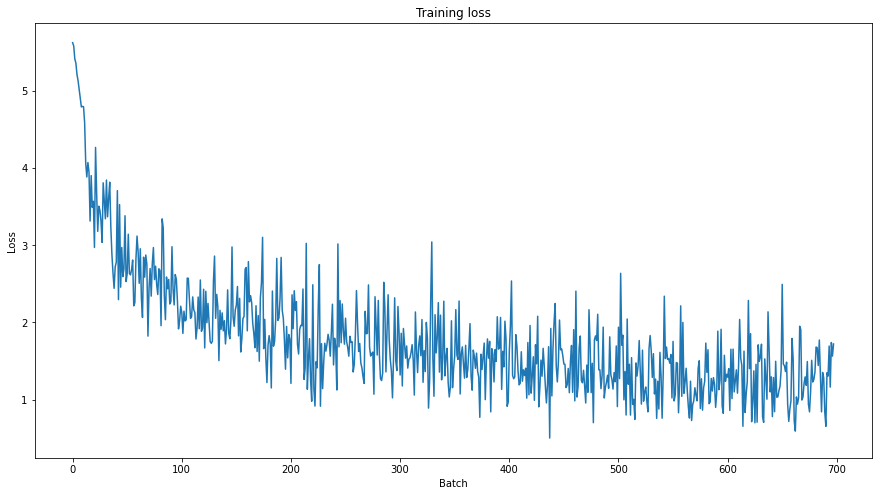

In [27]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [ ]:
input_file = '/content/drive/My Drive/dev-v2.0.json'
val_examples = read_squad_examples(input_file=input_file,
                                is_training=False,
                                version_2_with_negative=True
                                )

doc_stride = 128
max_seq_length = 256
max_query_length = 64
cached_features_file = '/content/drive/My Drive/cache_validation'


# Cache features for faster loading
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=val_examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=False)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [ ]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_example_index, all_cls_index, all_p_mask)

In [ ]:
validation_sampler = SequentialSampler(dataset)
validation_dataloader = DataLoader(dataset, sampler=validation_sampler, batch_size=batch_size, drop_last=True)

In [ ]:
def evaluate(model, tokenizer):
  print("***** Running evaluation *****")
  print("  Num examples = %d" % len(dataset))
  print("  Batch size = %d" % batch_size)
  all_results = []
  predict_file = '/content/drive/My Drive/dev-v2.0.json'
  for batch in tqdm(validation_dataloader, desc="Evaluating", miniters=100, mininterval=5.0):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2]
                }
      example_indices = batch[3]
      outputs = model(**inputs)

    for i, example_index in enumerate(example_indices):
      eval_feature = features[example_index.item()]
      unique_id = int(eval_feature.unique_id)

      result = RawResult(unique_id    = unique_id,
                         start_logits = to_list(outputs[0][i]),
                         end_logits   = to_list(outputs[1][i]))
      all_results.append(result)

  # Compute predictions
  output_prediction_file = "/content/drive/My Drive/predictions.json"
  output_nbest_file = "/content/drive/My Drive/nbest_predictions.json"
  output_null_log_odds_file = "/content/drive/My Drive/null_odds.json"
  output_dir = "/content/drive/My Drive/predict_results"

  write_predictions(val_examples, features, all_results, 10,
                  30, True, output_prediction_file,
                  output_nbest_file, output_null_log_odds_file, False,
                  True, 0.0)

  # Evaluate with the official SQuAD script
  evaluate_options = EVAL_OPTS(data_file=predict_file,
                               pred_file=output_prediction_file,
                               na_prob_file=output_null_log_odds_file,
                               out_image_dir=None)
  results = evaluate_on_squad(evaluate_options)
  return results

In [ ]:
results = evaluate(model, tokenizer)